# Análisis de Productos

Análisis visual del rendimiento de productos, categorías y precios.

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (14, 6)

### Cargar dataset consolidado

In [8]:
df = pd.read_csv('../data/processed/datos_consolidados.csv')
df['fecha'] = pd.to_datetime(df['fecha'])
print(f"✓ {df.shape[0]} registros | {df['id_producto'].nunique()} productos | {df['categoria'].nunique()} categorías")

✓ 343 registros | 95 productos | 2 categorías


## Rendimiento por Categoría

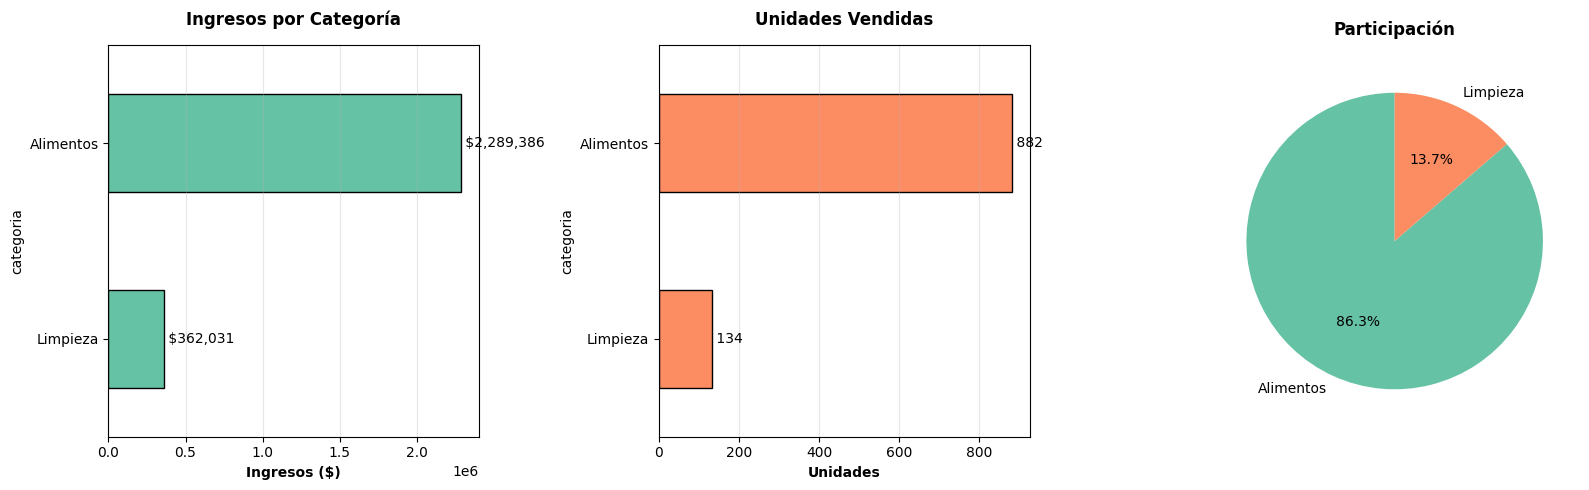

In [9]:
categorias = df.groupby('categoria').agg({'importe': 'sum', 'cantidad': 'sum'}).round(0)
categorias.columns = ['Ingresos', 'Unidades']

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Ingresos
categorias.sort_values('Ingresos', ascending=True).plot(kind='barh', y='Ingresos', ax=axes[0], color='#66c2a5', legend=False, edgecolor='black')
axes[0].set_title('Ingresos por Categoría', fontweight='bold', pad=15)
axes[0].set_xlabel('Ingresos ($)', fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)
for i, v in enumerate(categorias.sort_values('Ingresos')['Ingresos']):
    axes[0].text(v, i, f' ${v:,.0f}', va='center')

# Unidades
categorias.sort_values('Unidades', ascending=True).plot(kind='barh', y='Unidades', ax=axes[1], color='#fc8d62', legend=False, edgecolor='black')
axes[1].set_title('Unidades Vendidas', fontweight='bold', pad=15)
axes[1].set_xlabel('Unidades', fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)
for i, v in enumerate(categorias.sort_values('Unidades')['Unidades']):
    axes[1].text(v, i, f' {v:,.0f}', va='center')

# Participación
axes[2].pie(categorias['Ingresos'], labels=categorias.index, autopct='%1.1f%%', startangle=90, colors=['#66c2a5', '#fc8d62'])
axes[2].set_title('Participación', fontweight='bold', pad=15)

plt.tight_layout()
plt.show()

## Top 10 Productos

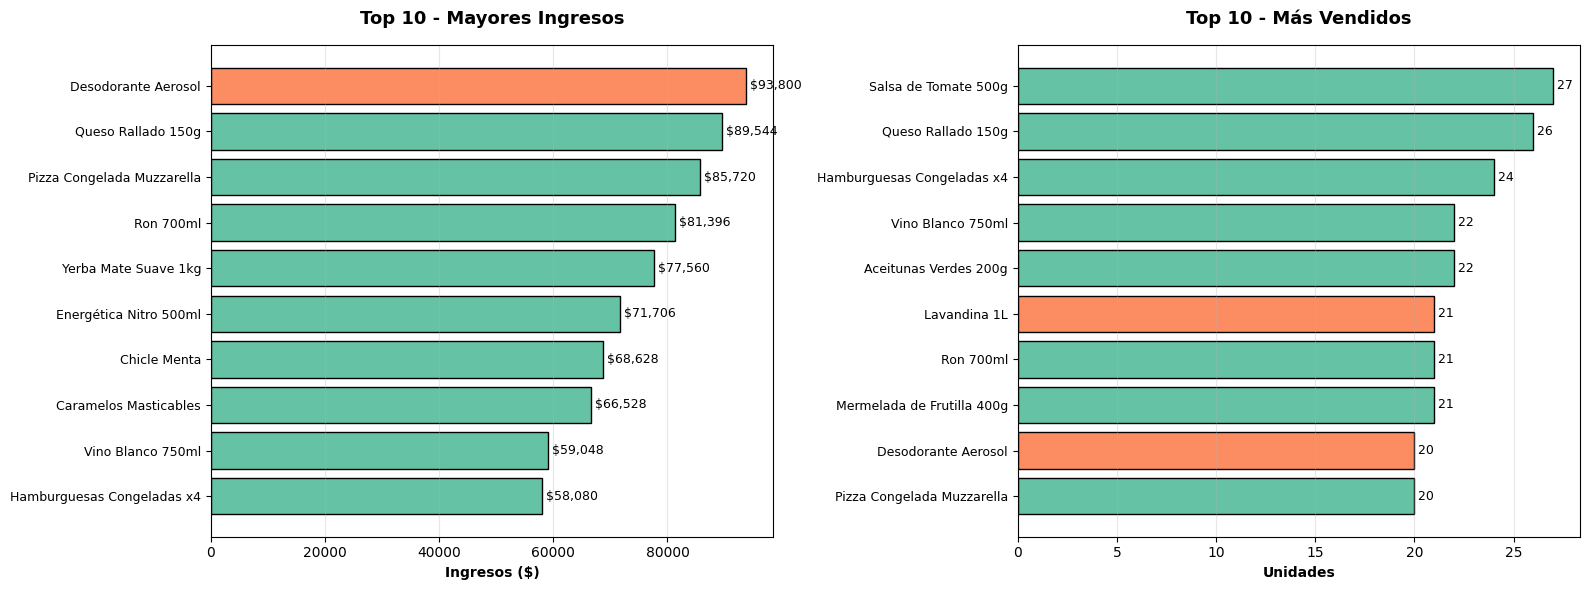

In [10]:
productos_agg = df.groupby(['nombre_producto', 'categoria']).agg({'importe': 'sum', 'cantidad': 'sum'}).reset_index()
top10_ingresos = productos_agg.nlargest(10, 'importe')
top10_unidades = productos_agg.nlargest(10, 'cantidad')

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top por ingresos
top10_i = top10_ingresos.sort_values('importe', ascending=True)
colors_i = ['#66c2a5' if cat == 'Alimentos' else '#fc8d62' for cat in top10_i['categoria']]
axes[0].barh(range(len(top10_i)), top10_i['importe'], color=colors_i, edgecolor='black')
axes[0].set_yticks(range(len(top10_i)))
axes[0].set_yticklabels([p[:35] for p in top10_i['nombre_producto']], fontsize=9)
axes[0].set_xlabel('Ingresos ($)', fontweight='bold')
axes[0].set_title('Top 10 - Mayores Ingresos', fontsize=13, fontweight='bold', pad=15)
axes[0].grid(axis='x', alpha=0.3)
for i, v in enumerate(top10_i['importe']):
    axes[0].text(v, i, f' ${v:,.0f}', va='center', fontsize=9)

# Top por unidades
top10_u = top10_unidades.sort_values('cantidad', ascending=True)
colors_u = ['#66c2a5' if cat == 'Alimentos' else '#fc8d62' for cat in top10_u['categoria']]
axes[1].barh(range(len(top10_u)), top10_u['cantidad'], color=colors_u, edgecolor='black')
axes[1].set_yticks(range(len(top10_u)))
axes[1].set_yticklabels([p[:35] for p in top10_u['nombre_producto']], fontsize=9)
axes[1].set_xlabel('Unidades', fontweight='bold')
axes[1].set_title('Top 10 - Más Vendidos', fontsize=13, fontweight='bold', pad=15)
axes[1].grid(axis='x', alpha=0.3)
for i, v in enumerate(top10_u['cantidad']):
    axes[1].text(v, i, f' {v}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

## Análisis de Precios

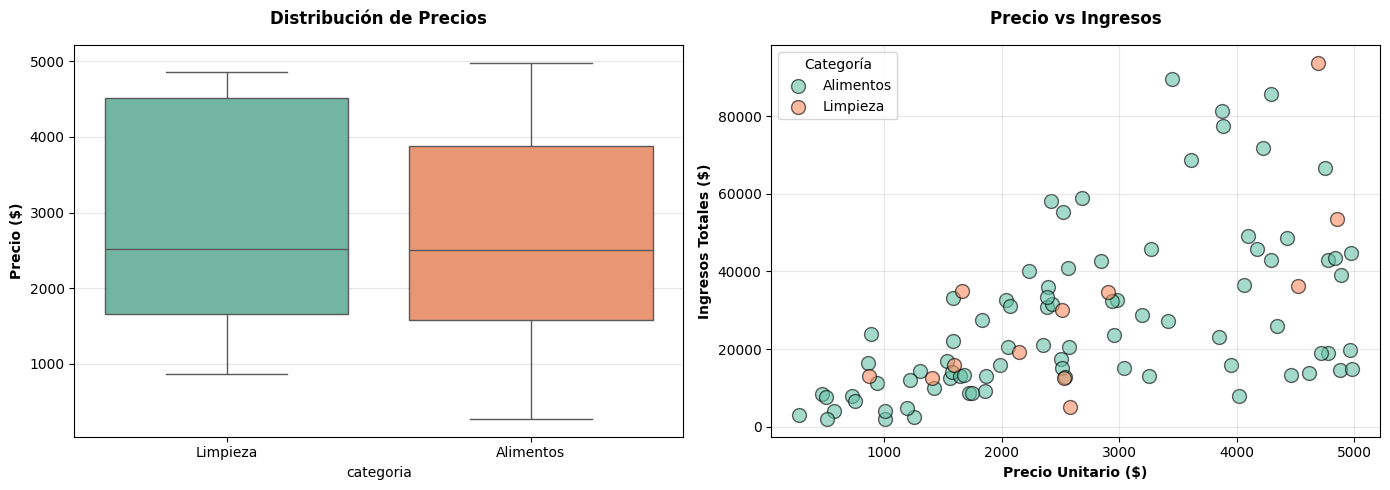

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Boxplot
sns.boxplot(data=df, x='categoria', y='precio_unitario', ax=axes[0], palette='Set2')
axes[0].set_title('Distribución de Precios', fontweight='bold', pad=15)
axes[0].set_ylabel('Precio ($)', fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Scatter: Precio vs Ingresos
scatter_data = df.groupby('nombre_producto').agg({'precio_unitario': 'mean', 'importe': 'sum', 'categoria': 'first'}).reset_index()
for cat, color in [('Alimentos', '#66c2a5'), ('Limpieza', '#fc8d62')]:
    data_cat = scatter_data[scatter_data['categoria'] == cat]
    axes[1].scatter(data_cat['precio_unitario'], data_cat['importe'], alpha=0.6, s=100, label=cat, color=color, edgecolors='black')

axes[1].set_xlabel('Precio Unitario ($)', fontweight='bold')
axes[1].set_ylabel('Ingresos Totales ($)', fontweight='bold')
axes[1].set_title('Precio vs Ingresos', fontweight='bold', pad=15)
axes[1].legend(title='Categoría')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Correlación de Métricas

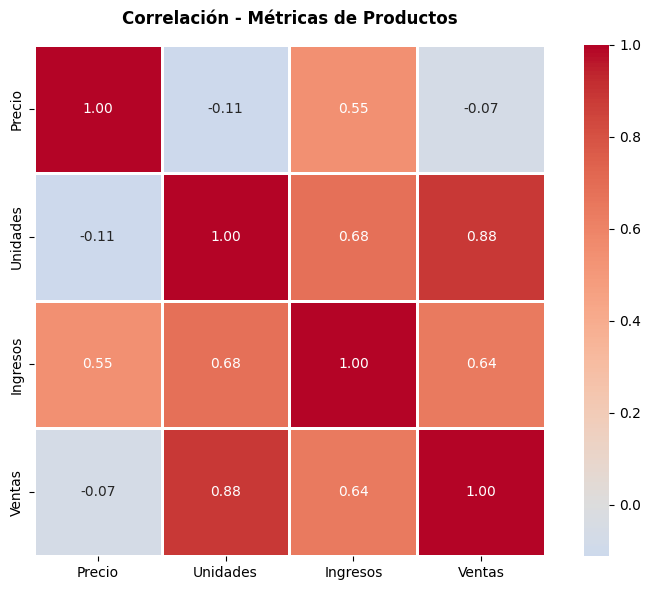

Unidades vs Ingresos: 0.68
Precio vs Ingresos: 0.55


In [12]:
producto_metricas = df.groupby('nombre_producto').agg({
    'precio_unitario': 'mean',
    'cantidad': 'sum',
    'importe': 'sum',
    'id_venta': 'nunique'
}).reset_index()
producto_metricas.columns = ['Producto', 'Precio', 'Unidades', 'Ingresos', 'Ventas']

fig, ax = plt.subplots(figsize=(8, 6))
correlacion = producto_metricas[['Precio', 'Unidades', 'Ingresos', 'Ventas']].corr()
sns.heatmap(correlacion, annot=True, fmt='.2f', cmap='coolwarm', center=0, square=True, linewidths=1, ax=ax)
ax.set_title('Correlación - Métricas de Productos', fontsize=12, fontweight='bold', pad=15)
plt.tight_layout()
plt.show()

print(f"Unidades vs Ingresos: {correlacion.loc['Unidades', 'Ingresos']:.2f}")
print(f"Precio vs Ingresos: {correlacion.loc['Precio', 'Ingresos']:.2f}")